In [1]:
import torch
import pyro
import numpy as np
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


import matplotlib.pyplot as plt

/home/soumik/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

mu_true = torch.tensor([25.0,60.0])
sigma_true = torch.tensor([[4.0,8.0],[8.0,25.0]])

n = 100

x = dist.MultivariateNormal(mu_true,sigma_true).sample((n,))


In [3]:
def model(data):
    # Prior mu
    mu = pyro.sample("mu",dist.MultivariateNormal(torch.zeros(2), 100*torch.eye(2)))

    # Prior sigma
    scale = pyro.sample("scale", dist.LogNormal(torch.zeros(2),torch.ones(2)))
    #corr = pyro.sample("corr", dist.LKJCorrCholesky(dim = 2, concentration = 2.0))
    #corr = pyro.sample("corr", dist.LKJCorrCholesky(dimension = 2, concentration=2.0))
    corr = torch.eye(2)
    

    L = torch.diag(scale)
    sigma = L @ L.T

    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", dist.MultivariateNormal(mu, covariance_matrix=sigma), obs = data)



In [4]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples= 10000, warmup_steps= 2000, num_chains=1)
mcmc.run(x)

Sample: 100%|██████████| 12000/12000 [01:07, 178.82it/s, step size=8.17e-01, acc. prob=0.891]


In [5]:
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples["mu"]
scale_samples = posterior_samples["scale"]
#corr_samples = posterior_samples["corr"]


#Reconstruct Covariance Matrix

cov_samples = torch.matmul(torch.diag_embed(scale_samples),
                           (torch.diag_embed(scale_samples)).transpose(-1, -2))

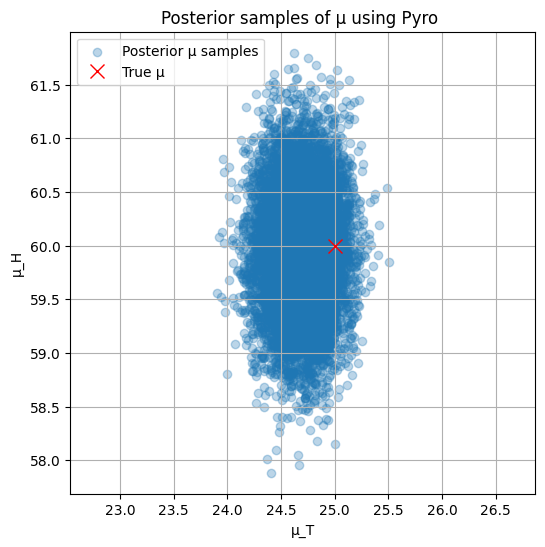

In [6]:
mu_samples_np = mu_samples.detach().numpy()

plt.figure(figsize = (6,6))
plt.scatter(mu_samples_np[:,0], mu_samples_np[:,1], alpha = 0.3, label = "Posterior μ samples")
plt.plot(mu_true[0], mu_true[1], "rx", markersize = 10, label = "True μ" )
plt.xlabel("μ_T")
plt.ylabel("μ_H")
plt.title("Posterior samples of μ using Pyro ")
plt.grid(True)
plt.legend()
plt.axis("Equal")
plt.show()